<center><img src='./Figs/cs-logo.png' width=200></center>



<h6><center></center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center>TP6 : Segmentation d'images </center>
<hr style=" border:none; height:3px;">
</h1>


L'objectif de ce TPs est de mettre en application les différentes approches de segmentation vues dans le cours et notamment :
 + Les approches basées sur le clustering
 + L'approche super-pixels
 

## Partie 1 : Segmentation par clustering (d'après CS 131)

Dans cette partie, il s'agit d'utiliser des algorithmes de clustering pour la segmentation d'images. Elle consiste en trois exercices dépendants :

 1. Exercice 1 : implémentation de deux algorithmes classiques de clustering : k-means et clustering hiérarchique (HAC)
 2. Exercice 2 : construction d'un vecteur de caractéristiques au niveau des pixels prenant en compte la couleur et la position.
 3. Exercice 3 : évaluation quantitative de l'approche de segmentation.

### Exercice 1 : Algorithmes de clustering

Appliquer le code ci-dessous qui permet de générer un ensemble de 4 clusters de points.


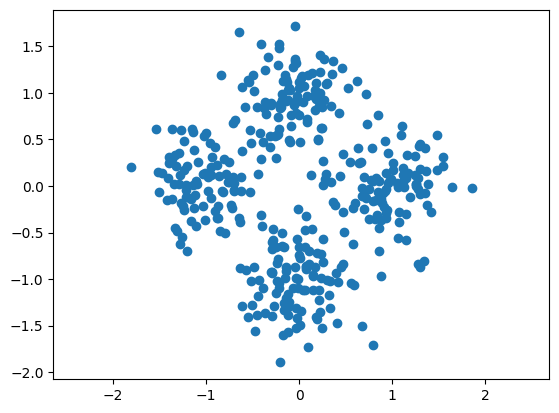

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

# Generate random data points for clustering

# Set seed for consistency
np.random.seed(0)

# Cluster 1
mean1 = [-1, 0]
cov1 = [[0.1, 0], [0, 0.1]]
X1 = np.random.multivariate_normal(mean1, cov1, 100)

# Cluster 2
mean2 = [0, 1]
cov2 = [[0.1, 0], [0, 0.1]]
X2 = np.random.multivariate_normal(mean2, cov2, 100)

# Cluster 3
mean3 = [1, 0]
cov3 = [[0.1, 0], [0, 0.1]]
X3 = np.random.multivariate_normal(mean3, cov3, 100)

# Cluster 4
mean4 = [0, -1]
cov4 = [[0.1, 0], [0, 0.1]]
X4 = np.random.multivariate_normal(mean4, cov4, 100)

# Merge two sets of data points
X = np.concatenate((X1, X2, X3, X4))

# Plot data points
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.show()


#### Algorithme k-means

Compléter le code ci-dessous pour avoir une implémentation de l'algorithme k-means.

In [2]:
import numpy as np
import random
from scipy.spatial.distance import squareform, pdist

### Clustering Methods
def kmeans(features, k, num_iters=100):
    """ Use kmeans algorithm to group features into k clusters.
    K-Means algorithm can be broken down into following steps:
        1. Randomly initialize cluster centers
        2. Assign each point to the closest center
        3. Compute new center of each cluster
        4. Stop if cluster assignments did not change
        5. Go to step 2
    Args:
        features - Array of N features vectors. Each row represents a feature
            vector.
        k - Number of clusters to form.
        num_iters - Maximum number of iterations the algorithm will run.
    Returns:
        assignments - Array representing cluster assignment of each point.
            (e.g. i-th point is assigned to cluster assignments[i])
    """

    N, D = features.shape

    assert N >= k, 'Number of clusters cannot be greater than number of points'

    # Randomly initalize cluster centers
    idxs = np.random.choice(N, size=k, replace=False)
    centers = features[idxs]
    assignments = np.zeros(N)

    for n in range(num_iters):
        for i in range(N):
            assignments[i] = np.argmin(np.sum((features[i] - centers)**2, axis=1))
        tmp = centers.copy()
        for j in range(k):
            centers[j] = np.mean(features[assignments == j], axis=0)
        if np.allclose(tmp, centers):
            break

    return assignments


Tester votre algorithme sur le jeu de données synthétique et mesurer son temps d'exécution en exécutant le code ci-dessous.

kmeans running time: 0.088766 seconds.


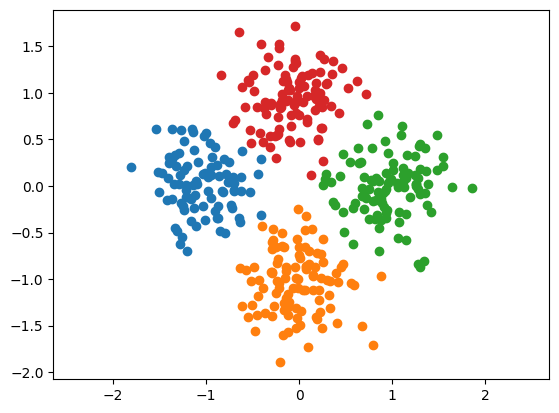

In [3]:
from time import time
np.random.seed(0)
start = time()
assignments = kmeans(X, 4)
end = time()

kmeans_runtime = end - start

print("kmeans running time: %f seconds." % kmeans_runtime)

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

A l'aide des fonctions de la bibliothèque numpy, essayez de rendre le calcul plus rapide.


In [4]:
def kmeans_fast(features, k, num_iters=100):
    """ Use kmeans algorithm to group features into k clusters.
    This function makes use of numpy functions and broadcasting to speed up the
    first part(cluster assignment) of kmeans algorithm.
    Hints
    - You may find np.repeat and np.argmin useful
    Args:
        features - Array of N features vectors. Each row represents a feature
            vector.
        k - Number of clusters to form.
        num_iters - Maximum number of iterations the algorithm will run.
    Returns:
        assignments - Array representing cluster assignment of each point.
            (e.g. i-th point is assigned to cluster assignments[i])
    """

    N, D = features.shape

    assert N >= k, 'Number of clusters cannot be greater than number of points'

    # Randomly initalize cluster centers
    idxs = np.random.choice(N, size=k, replace=False)
    centers = features[idxs]
    assignments = np.zeros(N)

    for n in range(num_iters):
        f_tmp = np.tile(features, (k, 1))
        c_tmp = np.repeat(centers, N, axis=0)
        assignments = np.argmin(np.sum((f_tmp - c_tmp)**2, axis=1).reshape(k, N), axis=0)
        tmp = centers.copy()
        for j in range(k):
            centers[j] = np.mean(features[assignments == j], axis=0)
        if np.allclose(tmp, centers):
            break

    return assignments


Tester votre fonction sur le jeu de données synthétiques.

kmeans running time: 0.012719 seconds.
6.979174 times faster!


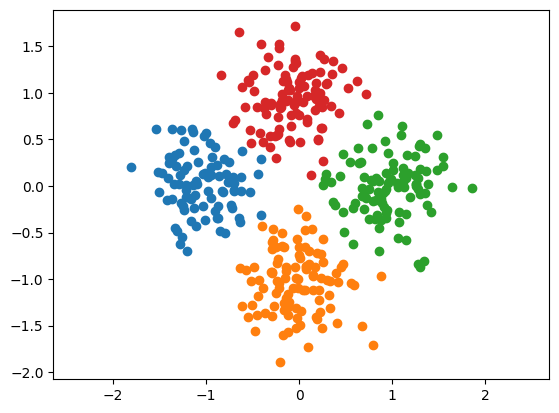

In [5]:
np.random.seed(0)
start = time()
assignments = kmeans_fast(X, 4)
end = time()

kmeans_fast_runtime = end - start
print("kmeans running time: %f seconds." % kmeans_fast_runtime)
print("%f times faster!" % (kmeans_runtime / kmeans_fast_runtime))

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

#### Clustering hiérarchique

Compléter le code ci-dessous pour avoir une implémentation de l'algorithme de clustering hiérarchique.

In [6]:


def hierarchical_clustering(features, k):
    """ Run the hierarchical agglomerative clustering algorithm.
    The algorithm is conceptually simple:
    Assign each point to its own cluster
    While the number of clusters is greater than k:
        Compute the distance between all pairs of clusters
        Merge the pair of clusters that are closest to each other
    We will use Euclidean distance to define distance between clusters.
    Recomputing the centroids of all clusters and the distances between all
    pairs of centroids at each step of the loop would be very slow. Thankfully
    most of the distances and centroids remain the same in successive
    iterations of the outer loop; therefore we can speed up the computation by
    only recomputing the centroid and distances for the new merged cluster.
    Even with this trick, this algorithm will consume a lot of memory and run
    very slowly when clustering large set of points. In practice, you probably
    do not want to use this algorithm to cluster more than 10,000 points.
    Args:
        features - Array of N features vectors. Each row represents a feature
            vector.
        k - Number of clusters to form.
    Returns:
        assignments - Array representing cluster assignment of each point.
            (e.g. i-th point is assigned to cluster assignments[i])
    """



    N, D = features.shape

    assert N >= k, 'Number of clusters cannot be greater than number of points'

    # Assign each point to its own cluster
    assignments = np.arange(N)
    centers = np.copy(features)
    n_clusters = N

    while n_clusters > k:
        distances = pdist(centers)
        matrixDistances = squareform(distances)
        matrixDistances = np.where(matrixDistances != 0.0, matrixDistances, 1e10)
        minValue = np.argmin(matrixDistances)
        min_i = minValue // n_clusters
        min_j = minValue - min_i * n_clusters
        if min_j < min_i:
            min_i, min_j = min_j, min_i
        for i in range(N):
            if assignments[i] == min_j:
                assignments[i] = min_i
        for i in range(N):
            if assignments[i] > min_j:
                assignments[i] -= 1
        centers = np.delete(centers, min_j, axis = 0)
        centers[min_i] = np.mean(features[assignments == min_i], axis = 0)
        n_clusters -= 1

    return assignments


Tester le sur le jeu de données synthétiques.

hierarchical_clustering running time: 5.728535 seconds.


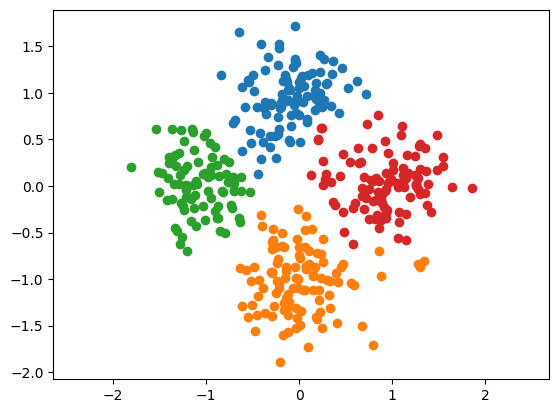

In [7]:
start = time()
assignments = hierarchical_clustering(X, 4)
end = time()

print("hierarchical_clustering running time: %f seconds." % (end - start))

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

### Exercice 2  : Application à la segmentation d'images

Avant de pouvoir utiliser un algorithme de clustering pour segmenter une image, nous devons calculer un vecteur de caractéristiques pour chaque pixel. Le vecteur de caractéristiques pour chaque pixel doit coder les propriétés estimées utiles pour une bonne segmentation. Plus concrètement, pour une paire de pixels $p_i$ et $p_j$ avec les vecteurs caractéristiques correspondants $f_i$ et $f_j$, la distance entre $f_i$ et $f_j$ doit être petite si nous pensons que $p_i$ et $p_j$ doivent être placés dans le même cluster (region ici) et grande sinon.



Charger et afficher une image

In [8]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import cv2

def loadImagebis(src):
    img=cv2.imread(src,1)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb,interpolation='nearest')
    plt.show()
    return rgb

    
img=loadImagebis('./Lab5/Images/house.jpg')

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


#### Caractéristiques de couleur

Une manière assez simple de caractériser un pixel est d'utiliser la valeur de la couleur en chaque pixel. Compléter la fonction ci-dessous.


In [ ]:
def color_features(img):
    """ Represents a pixel by its color.
    Args:
        img - array of shape (H, W, C)
    Returns:
        features - array of (H * W, C)
    """
    H, W, C = img.shape
    print(H, W, C)
    color = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    features = np.zeros((H*W, C))

    features = color.reshape(H*W, C)

    return features


In [ ]:
features = color_features(img)
features.dtype

720 1280 3


dtype('float32')

Tester sur votre image le clustering k-means rapide et eventuellement les autres approches de clustering en ne considérant que ce vecteur de caractéristiques.

720 1280 3


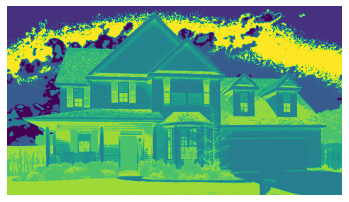

In [ ]:
np.random.seed(0)
features = color_features(img)
H, W, C = img.shape

# Sanity checks
assert features.shape == (H * W, C),\
    "Incorrect shape! Check your implementation."

assert features.dtype == np.float32,\
    "dtype of color_features should be float."

assignments = kmeans_fast(features, 8)
segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

La fonction ci-dessous permet de visualiser chaque région comme la moyenne des pixels de la région.

In [ ]:
def visualize_mean_color_image(img, segments):

    img = img_as_float(img)
    k = np.max(segments) + 1
    mean_color_img = np.zeros(img.shape)

    for i in range(k):
        mean_color = np.mean(img[segments == i], axis=0)
        mean_color_img[segments == i] = mean_color

    plt.imshow(mean_color_img)
    plt.axis('off')
    plt.show()

Appliquer la à votre image.

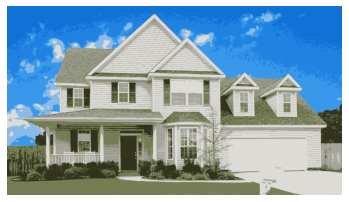

In [ ]:
visualize_mean_color_image(img, segments)

#### Caractéristiques de couleur et de position

Un autre vecteur de caractéristique simple pour un pixel est de concaténer sa couleur et sa position dans l'image. En d'autres termes, pour un pixel de couleur $(r, g, b)$ situé à la position $(x, y)$ dans l'image, son vecteur de caractéristique serait $(r, g, b, x, y)$. Cependant, les caractéristiques de couleur et de position peuvent avoir des plages radicalement différentes ; par exemple, chaque canal de couleur d'une image peut se situer dans la plage $[0, 1)$, tandis que la position de chaque pixel peut avoir une plage beaucoup plus large. Une mauvaise mise à l'échelle entre les différentes caractéristiques du vecteur de caractéristiques peut entraîner un mauvais comportement des algorithmes de clustering.

Une façon de corriger cela est d'appliquer une normalisation au vecteur de caractéristiques. L'un des types de normalisation les plus simples consiste à forcer chaque caractéristique à avoir une moyenne et une variance unitaire nulles.

Compléter le code ci-dessous pour construire un tel vecteur de caractéristiques.


In [ ]:
def color_position_features(img):
    """ Represents a pixel by its color and position.
    Combine pixel's RGB value and xy coordinates into a feature vector.
    i.e. for a pixel of color (r, g, b) located at position (x, y) in the
    image. its feature vector would be (r, g, b, x, y).
    Don't forget to normalize features.
    Hints
    - You may find np.mgrid and np.dstack useful
    - You may use np.mean and np.std
    Args:
        img - array of shape (H, W, C)
    Returns:
        features - array of (H * W, C+2)
    """
    H, W, C = img.shape
    color = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    features = np.zeros((H*W, C+2))

    locations = np.dstack(np.mgrid[0 : H, 0 : W]).reshape((H * W, 2))
    features[:, 0 : C] = color.reshape((H * W, C))
    features[:, C : C + 2] = locations
    features = (features - np.mean(features, axis = 0)) / np.std(features, axis = 0)
    return features

Tester sur votre image le clustering k-means rapide et eventuellement les autres approches de clustering en considérant ce nouveau vecteur de caractéristiques.

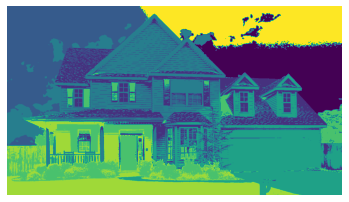

In [ ]:
np.random.seed(0)

features = color_position_features(img)

# Sanity checks
assert features.shape == (H * W, C + 2),\
    "Incorrect shape! Check your implementation."

assert features.dtype == np.float,\
    "dtype of color_features should be float."

assignments = kmeans_fast(features, 8)
segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

Visualiser votre clustering à l'aide de la fonction `visualize_mean_color_image``


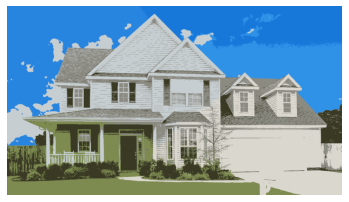

In [ ]:
visualize_mean_color_image(img, segments)

Essayer d'améliorer le résultat du clustering en ajoutant et en calculant les caractéristiques qui vous semblent pertinentes pour la segmentation.


In [ ]:
def my_features(img):
    """ Implement your own features
    Args:
        img - array of shape (H, W, C)
    Returns:
        features - array of (H * W, C)
    """
    features = None
    ### YOUR CODE HERE
    pass
    ### END YOUR CODE
    return features

In [ ]:
# To complete

### Exercice 3  : Evaluation quantitative

Il s'agit ici, sur un petit ensemble de données d'images de chats et des segmentations de ces images en avant-plan (chats) et en arrière-plan (tout le reste) d'évaluer les algorithmes de segmentation. 

Nous pouvons transposer la tâche de segmentation en un problème de classification binaire, où nous devons classer chaque pixel d'une image en avant-plan (positif) ou en arrière-plan (négatif). Compte tenu de la vérité terrain, la précision d'une segmentation est de $(TP+TN)/(P+N)$.
Compléter la fonction ci-dessous permettant de calculer la précision.

In [ ]:
def compute_accuracy(mask_gt, mask):
    """ Compute the pixel-wise accuracy of a foreground-background segmentation
        given a ground truth segmentation.
    Args:
        mask_gt - The ground truth foreground-background segmentation. A
            logical of size H x W where mask_gt[y, x] is 1 if and only if
            pixel (y, x) of the original image was part of the foreground.
        mask - The estimated foreground-background segmentation. A logical
            array of the same size and format as mask_gt.
    Returns:
        accuracy - The fraction of pixels where mask_gt and mask agree. A
            bigger number is better, where 1.0 indicates a perfect segmentation.
    """


    accuracy = None
    accuracy = np.mean(mask_gt == mask)


    return accuracy

Tester votre fonction avec le code ci-dessous.

Accuracy: 0.97


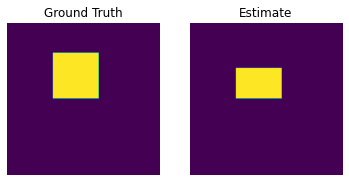

In [ ]:
mask_gt = np.zeros((100, 100))
mask = np.zeros((100, 100))

# Test compute_accracy function
mask_gt[20:50, 30:60] = 1
mask[30:50, 30:60] = 1

accuracy = compute_accuracy(mask_gt, mask)

print('Accuracy: %0.2f' % (accuracy))
if accuracy != 0.97:
    print('Check your implementation!')

plt.subplot(121)
plt.imshow(mask_gt)
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(122)
plt.imshow(mask)
plt.title('Estimate')
plt.axis('off')

plt.show()

Le code ci-dessous vous permet de tester la fonction de votre choix sur le jeu de données fourni dans le répertoire [Data](./Data).

In [ ]:
def evaluate_segmentation(mask_gt, segments):
    """ Compare the estimated segmentation with the ground truth.
    Note that 'mask_gt' is a binary mask, while 'segments' contain k segments.
    This function compares each segment in 'segments' with the ground truth and
    outputs the accuracy of the best segment.
    Args:
        mask_gt - The ground truth foreground-background segmentation. A
            logical of size H x W where mask_gt[y, x] is 1 if and only if
            pixel (y, x) of the original image was part of the foreground.
        segments - An array of the same size as mask_gt. The value of a pixel
            indicates the segment it belongs.
    Returns:
        best_accuracy - Accuracy of the best performing segment.
            0 <= accuracy <= 1, where 1.0 indicates a perfect segmentation.
    """

    num_segments = np.max(segments) + 1
    best_accuracy = 0

    # Compare each segment in 'segments' with the ground truth
    for i in range(num_segments):
        mask = (segments == i).astype('uint8')
        accuracy = compute_accuracy(mask_gt, mask)
        best_accuracy = max(accuracy, best_accuracy)

    return best_accuracy



def load_dataset(data_dir):
    """
    This function assumes 'gt' directory contains ground truth segmentation
    masks for images in 'imgs' dir. The segmentation mask for image
    'imgs/aaa.jpg' is 'gt/aaa.png'
    """

    imgs = []
    gt_masks = []

    # Load all the images under 'data_dir/imgs' and corresponding
    # segmentation masks under 'data_dir/gt'.
    for fname in sorted(os.listdir(os.path.join(data_dir, 'imgs'))):
        if fname.endswith('.jpg'):
            # Load image
            img = cv2.imread(os.path.join(data_dir, 'imgs', fname))
            imgs.append(img)

            # Load corresponding gt segmentation mask
            mask_fname = fname[:-4] + '.png'
            gt_mask = cv2.imread(os.path.join(data_dir, 'gt', mask_fname),0)
            gt_masks.append(gt_mask)

    return imgs, gt_masks








In [ ]:
# Load a small segmentation dataset
imgs, gt_masks = load_dataset('./Data/Lab6/')

In [ ]:
mean_accuracy = 0.0

segmentations = []

for i, (img, gt_mask) in enumerate(zip(imgs, gt_masks)):
    # Compute a segmentation for this image
    H, W, C = img.shape
    features = color_position_features(img)
    assignments = kmeans_fast(features, 3)
    segments = assignments.reshape((H, W)) 
    segmentations.append(segments)
    
    # Evaluate segmentation
    accuracy = evaluate_segmentation(gt_mask, segments)
    
    print('Accuracy for image %d: %0.4f' %(i, accuracy))
    mean_accuracy += accuracy
    
mean_accuracy = mean_accuracy / len(imgs)
print('Mean accuracy: %0.4f' % mean_accuracy)

Accuracy for image 0: 0.6463
Accuracy for image 1: 0.6492
Accuracy for image 2: 0.6763
Accuracy for image 3: 0.8457
Accuracy for image 4: 0.7253
Accuracy for image 5: 0.3752
Accuracy for image 6: 0.4232
Accuracy for image 7: 0.2236
Accuracy for image 8: 0.6170
Accuracy for image 9: 0.8047
Accuracy for image 10: 0.6583
Accuracy for image 11: 0.7747
Accuracy for image 12: 0.6775
Accuracy for image 13: 0.4716
Accuracy for image 14: 0.4523
Accuracy for image 15: 0.2980
Mean accuracy: 0.5824


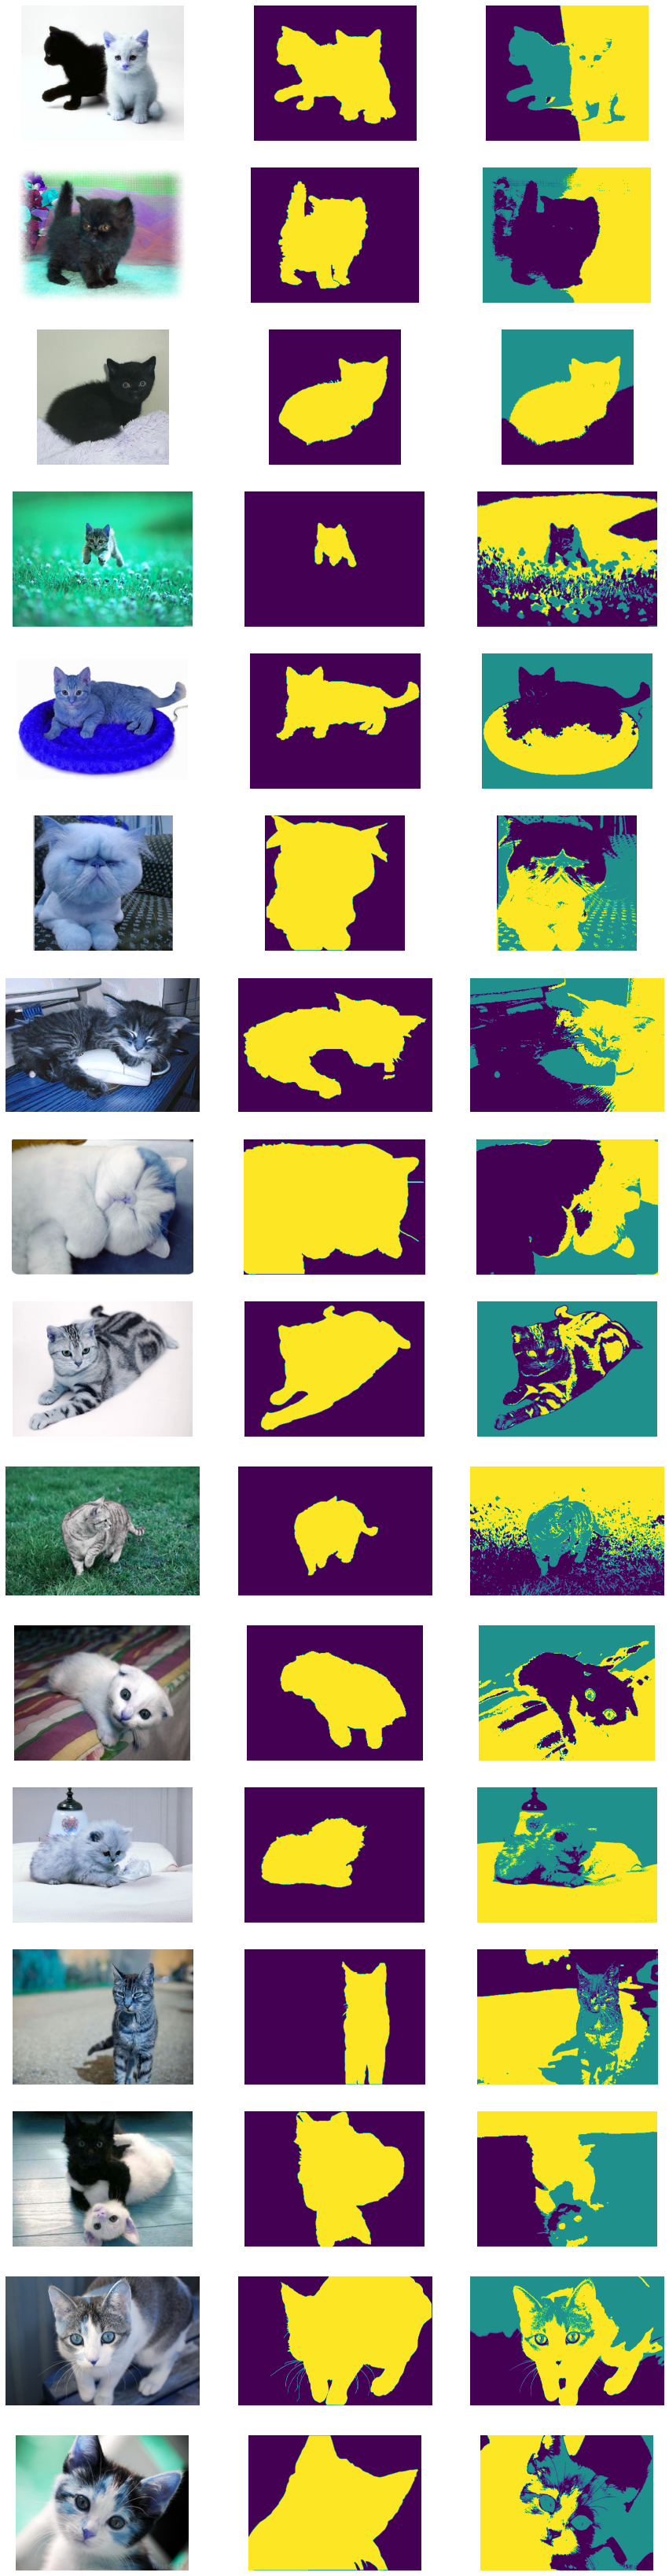

In [ ]:
# Visualize segmentation results

N = len(imgs)
plt.figure(figsize=(15,60))
for i in range(N):

    plt.subplot(N, 3, (i * 3) + 1)
    plt.imshow(imgs[i])
    plt.axis('off')

    plt.subplot(N, 3, (i * 3) + 2)
    plt.imshow(gt_masks[i])
    plt.axis('off')

    plt.subplot(N, 3, (i * 3) + 3)
    plt.imshow(segmentations[i], cmap='viridis')
    plt.axis('off')

plt.show()

## Partie 2 : Approche super-pixels.



Dans cette partie il s'agit de mettre en place l'approche de segmentation par super-pixels décrite dans le cours et avec plus de détails [ici](https://www.iro.umontreal.ca/~mignotte/IFT6150/Articles/SLIC_Superpixels.pdf).

Le principe de l'algorithme SLIC (Simple Linear Iterative Clustering) est le suivant :
 + les pixels sont groupés en superpixels rectangulaires et réguliers
 + chaque superpixel est décrit par sa couleur moyenne et la localisation de son barycentre
 + chaque pixel est ré-attribué au superpixel dont il est le plus proche en terme de couleur et de localisation
 + les étapes 2 et 3 sont répétées jusqu'à ce que les superpixels soient stables
 


### Exercice 1 : SLIC

Ecrire une fonction qui prend en entrée une image, un espace colorimétrique, un nombre de segments et qui applique l'algorithme SLIC. 
Pour cela vous pouvez par exemple vous inspirer ou utiliser l'implémentation qui a été faite dans la bibliothèque scikit-image [ici](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic) dont le code source est disponible [ici](https://github.com/scikit-image/scikit-image/blob/master/skimage/segmentation/slic_superpixels.py#L11)

In [ ]:
# TO Complete

Tester sur plusieurs images en jouant sur les différents paramètres possibles.

In [ ]:
# TO COMPLETE

### Exercice 2 : Segmentation par apprentissage.

Comme décrit dans le cours, nous allons maintenant utiliser les super-pixels et leur caractérisation pour modéliser la segmentation comme un problème d'apprentissage.
Il s'agira donc :
 + D'associer à chaque superpixel un vecteur caractéristique.
 + Constituer un ensemble d'apprentissage sur un petit nombre d'images de votre choix et un petit nombre de classes 
 + D'apprendre un modèle par exemple avec un SVM et de l'appliquer sur une nouvelle image.


#### Caractérisation des super-pixels

Décrire chaque superpixel par cinq valeurs numériques : trois pour sa couleur moyenne et deux pour la position de son barycentre.

In [ ]:
# TO COMPLETE

#### Base d'apprentissage

Il s'agit ici de constituer un petit ensemble d'apprentissage composé de quelques images de scènes de même type. Choisissez 3 à 4 classes que vous aimeriez segmenter dans l'image. Par exemple, dans des images de paysages de plages, les classes pourraient être `mer`, `sable`, `ciel` et `autre`. Il s'agira donc dans un premier temps de mettre en place un programme permettant à un utilisateur d'annoter les images de votre base avec ces 4 classes. Pour cela vous pourrez utiliser les fonctions de dessins d'opencv décrites [ici](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_drawing_functions/py_drawing_functions.html) pour dessiner des traits de couleurs différentes pour chacune des classes sur les images de votre base d'apprentissage. Vous pouvez ici aussi vous inspirer de [cette approche](https://github.com/opencv/opencv/blob/master/samples/python/grabcut.py) pour la partie annotation.

Ensuite, vous pouvez constituer une base d'apprentissage $(X,Y)$ en prenant pour chaque classe annotée, les superpixels correspondants (ceux qui correspondent au trait de couleur marqué pour la classe) et en prenant leur caractérisation.






In [ ]:
# TO COMPLETE  : Annotation

In [ ]:
# TO COMPLETE : constitution de la base d'aprentissage

#### Apprentissage

Apprendre un classifeur de superpixel à l'aide d'un SVM avec un noyau RBF. La documentation est [ici](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_ml/py_svm/py_svm_basics/py_svm_basics.html#svm-understanding). 

In [ ]:
# TO COMPLETE

Appliquer le sur une nouvelle image.

In [ ]:
# TO COMPLETE